<a href="https://colab.research.google.com/github/fatemes23/wind-speed-forecasting/blob/main/wind_speed_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# پیشبینی سری زمانی سرعت باد

In [ ]:
# import library that neads in project 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow import keras as keras
from keras import Sequential, layers, callbacks
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional , Dropout , ReLU , Add  , BatchNormalization ,Embedding,Bidirectional,LSTM
# Calculate MAE and RMSE
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error 
from keras.layers import MultiHeadAttention
from keras.layers import LayerNormalization
#from keras.layers import Dropout , ReLU , Add  , BatchNormalization ,Embedding,Bidirectional,LSTM

# Set random seed to get the same result after each time running the code
tf.random.set_seed(1234)

In [ ]:
#for connecting to google drive 
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


**read data set**

In [ ]:
#read CSV file 
daily_dataset = pd.read_csv('/content/gdrive/MyDrive/Colab_Notebooks/hw3/create-dataset-daily.csv',  engine='python')
daily_dataset

,time,air_temperature_mean,pressure,wind_direction,wind_speed
0,19950101,2.7,990.6667,263,6.7
1,19950102,0.6,1000.7083,301,4.1
2,19950103,-0.3,1027.3750,355,3.2
3,19950104,-2.8,1035.9584,86,1.6
4,19950105,-5.1,1034.5416,124,3.5
...,...,...,...,...,...
3648,20041227,3.0,1012.0000,350,4.4
3649,20041228,1.5,1008.8333,192,3.3
3650,20041229,2.4,1018.9167,280,3.1
3651,20041230,3.8,1027.3334,220,4.5


**اضاف کردن یک ستون(میانگین سرعت باد سه روز اخیر) به دیتاست برای تشخیص بهتر **

 
برای تشخیص بهتر در شبکه یک ستون به دیتاست اضاف میکنیم، این ستون در واقع میانگین سرعت باد سه روز گذشته در دیتاست است.


ستون avg_wind_speed اضاف شده است.




In [ ]:
daily_dataset.iloc[0:3, 4].mean(axis=0)
Avg_wind_speed_list = []
for i in range(2,len(daily_dataset.time)+2) :
   Avg_wind_speed_list.append(daily_dataset.iloc[i-2:i+1, 4].mean(axis=0))

daily_dataset['Avg_wind_speed'] = Avg_wind_speed_list
daily_dataset

,time,air_temperature_mean,pressure,wind_direction,wind_speed,Avg_wind_speed
0,19950101,2.7,990.6667,263,6.7,4.666667
1,19950102,0.6,1000.7083,301,4.1,2.966667
2,19950103,-0.3,1027.3750,355,3.2,2.766667
3,19950104,-2.8,1035.9584,86,1.6,2.700000
4,19950105,-5.1,1034.5416,124,3.5,2.600000
...,...,...,...,...,...,...
3648,20041227,3.0,1012.0000,350,4.4,3.600000
3649,20041228,1.5,1008.8333,192,3.3,3.633333
3650,20041229,2.4,1018.9167,280,3.1,3.933333
3651,20041230,3.8,1027.3334,220,4.5,4.350000


**Time Series Plot**


نمودار سرعت باد بر حسب زمان به صورت زیر است.



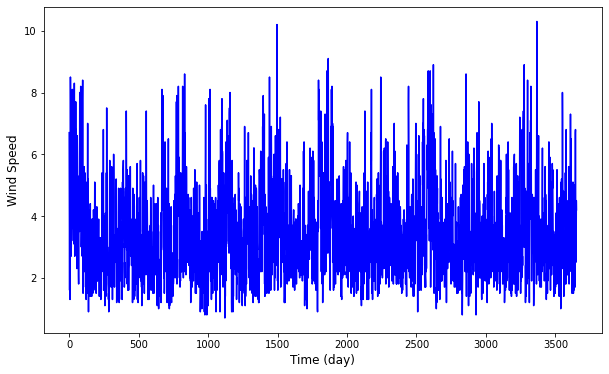

In [ ]:
# Define a function to draw time_series plot
def timeseries_plot (x_axis, y_axis, x_label):
    plt.figure(figsize = (10, 6))
    plt.plot(x_axis, y_axis, color ='blue')
    plt.xlabel(x_label, {'fontsize': 12}) 
    plt.ylabel('Wind Speed', {'fontsize': 12})
timeseries_plot(daily_dataset.index, daily_dataset.wind_speed, 'Time (day)')


#**pre-processing**

**check for missing value**


ابتدا ستون هایی که مقادیر بدون مقدار را دارند پیدا میکنیم.
همانطور که در نتیجه نشان داده شده است هیچ کدام از ستون ها بدون مقدار نیستند




In [ ]:
print('Total num of missing values:') 
print(daily_dataset.isna().sum())
print('')

Total num of missing values:
time                    0
air_temperature_mean    0
pressure                0
wind_direction          0
wind_speed              0
Avg_wind_speed          0
dtype: int64



[لینک مربوطه](https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/)


<div dir=rtl>

در این قسمت عملیات آماده سازی داده ترین و تست را داریم، در مسائل مربوط به سری زمانی معمولا برای دادههای ترین از یک ستون استفاده شده، اما در این پروژه سعی شده که از همه ستون‌های موجود در دیتاست  برای پیش بینی سرعت باد استفاده میشود.
برای این موضوع دو حرکت میتوان انجام داد :
1.	از داده های مربوط به زمان (t) استفاده کنیم که در آینده سرعت باد در زمان t+1 را پیشبینی کنیم.
2.	از داده‌های مربوط به زمان t-1 استفاده کنیم که در آینده سرعت با در زمان t  را پیشبینی کنیم.

 در این پروژه از حالت دوم استفاده شده است، همینطور که در خروجی این بلاک قابل مشاهده است، تمام اطلاعات موجود در زمان t-1 ، با سرعت باد در زمان t در یک ردیف در کنار یکدیگر قرار گرفته‌اند.
که در آینده از ستون هایی که برای زمان t-1 هستند برای xها استفاده می‌کنیم و از ستون سرعت باد در زمان t برای yها استفاده خواهیم کرد.
</div>


In [ ]:
def series_to_supervised(dataset , lookback=1) :
  
  #set name of columns
  cols = dataset.columns[1:]#after time col...
  new_dataset = pd.DataFrame()

  for col in cols :
    new_col = col+"(t-1)"
    new_dataset[new_col] = dataset[col]
    if (col == "wind_speed") :
      xt = col+"(t)"

  new_dataset[xt] = daily_dataset[ 'wind_speed'].shift(-1*lookback)
  new_dataset.drop(new_dataset.tail(lookback).index, inplace = True)
  return new_dataset

new_dataset_daily = series_to_supervised(daily_dataset)
new_dataset_daily

,air_temperature_mean(t-1),pressure(t-1),wind_direction(t-1),wind_speed(t-1),Avg_wind_speed(t-1),wind_speed(t)
0,2.7,990.6667,263,6.7,4.666667,4.1
1,0.6,1000.7083,301,4.1,2.966667,3.2
2,-0.3,1027.3750,355,3.2,2.766667,1.6
3,-2.8,1035.9584,86,1.6,2.700000,3.5
4,-5.1,1034.5416,124,3.5,2.600000,3.0
...,...,...,...,...,...,...
3647,2.8,1006.2083,42,2.5,3.400000,4.4
3648,3.0,1012.0000,350,4.4,3.600000,3.3
3649,1.5,1008.8333,192,3.3,3.633333,3.1
3650,2.4,1018.9167,280,3.1,3.933333,4.5


#نرمال سازی ستون های دیتاست

In [ ]:

values = new_dataset_daily.values
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_dataset = scaler.fit_transform(values)
print(scaled_dataset.shape)

(3652, 6)


<div dir=rtl>
جدا کردن داده ترین و تست 
70 درصد داده ها را به عنوان داده ترین و 30 درصد از آنها را به عنوان داده تست در نظر میگیریم.


In [ ]:
# split into train and test sets
train_size = int(len(scaled_dataset) * 0.67)
test_size = len(scaled_dataset) - train_size
train, test = scaled_dataset[0:train_size,:], scaled_dataset[train_size:len(scaled_dataset),:]
train.shape

(2446, 6)

<div dir=rtl>
مشخص کردن xو y 
<br>
همانطور که در دو قسمت قبل نیز گفته شد ستون wind_speed(t)  به عنوان ستون y و ستونهای دیگر که اطلاعات در زمان t-1 هستند به عنوان x در نظر گرفته میشوند.
<br>
و از این طریق مقادیر x-train , y-train , x-test , y-test بدست می آیند


In [ ]:
trainX = []
trainY = []
testX = []
testY = []
for item in train :
  trainX.append(item[0:5])
  trainY.append(item[5])
trainX = np.array(trainX)
trainY = np.array(trainY)

for item in test :
  testX.append(item[0:5])
  testY.append(item[5])
testX = np.array(testX)
testY = np.array(testY)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print(trainX.shape, trainY.shape, testX.shape, testY.shape)

(2446, 1, 5) (2446,) (1206, 1, 5) (1206,)


In [ ]:
trainX

array([[[0.37020314, 0.10316467, 0.7325905 , 0.625     , 0.5       ]],

       [[0.3227991 , 0.26891327, 0.8384401 , 0.35416666, 0.2616822 ]],

       [[0.30248305, 0.70907784, 0.9888579 , 0.2604167 , 0.23364483]],

       ...,

       [[0.55756205, 0.1740017 , 0.70473534, 0.78124994, 0.8411214 ]],

       [[0.62528217, 0.20563889, 0.76044565, 0.65624994, 0.6028037 ]],

       [[0.5711061 , 0.35832214, 0.67966574, 0.56249994, 0.45327097]]],
      dtype=float32)

# LSTM MODEL
<div dir=rtl>
در ابتدا به عنوان اولین شبکه مورد بررسی از شبکه lstm  استفاده میکنیم
<br>
که اندازه ورودی و خروجی را در آن مشخص میکنیم  مقدار خروجی را برابر 64 در نظر گرفته ایم.
<br>
بعد از آن از یک dence-layer استفاده شده است و خروجی آن مقدار یک در نظر گرفته میشود
سپس مدل را ایجاد میکنیم.
<br>
برای fit کردن مدل  100 epoch در نظر گفته شده است 
<br>
همینطور مقدار درصد validation data 20 درصد داده های تست در نظر گرفته شده است.
<br>
همینطور از early stopping  بعد از 30 نتیجه یکسان برای validation loss استفاده شده است 
<br>
شکل کلی شبکه در بلاک بعد مشخص شده است.

In [ ]:
# create and fit the LSTM network
# design network
lstm_model = Sequential()
lstm_model.add(LSTM(64, input_shape=(trainX.shape[1], trainX.shape[2])))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error', optimizer='adam')

early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',patience = 15)
history_lstm = lstm_model.fit(trainX, trainY, epochs = 100, validation_split = 0.2, batch_size = 32, shuffle = False, callbacks = [early_stop] , verbose=2)





Epoch 1/100
62/62 - 4s - loss: 0.0346 - val_loss: 0.0165 - 4s/epoch - 70ms/step
Epoch 2/100
62/62 - 0s - loss: 0.0186 - val_loss: 0.0132 - 204ms/epoch - 3ms/step
Epoch 3/100
62/62 - 0s - loss: 0.0149 - val_loss: 0.0106 - 179ms/epoch - 3ms/step
Epoch 4/100
62/62 - 0s - loss: 0.0119 - val_loss: 0.0086 - 179ms/epoch - 3ms/step
Epoch 5/100
62/62 - 0s - loss: 0.0099 - val_loss: 0.0071 - 200ms/epoch - 3ms/step
Epoch 6/100
62/62 - 0s - loss: 0.0085 - val_loss: 0.0061 - 227ms/epoch - 4ms/step
Epoch 7/100
62/62 - 0s - loss: 0.0073 - val_loss: 0.0052 - 184ms/epoch - 3ms/step
Epoch 8/100
62/62 - 0s - loss: 0.0063 - val_loss: 0.0044 - 184ms/epoch - 3ms/step
Epoch 9/100
62/62 - 0s - loss: 0.0054 - val_loss: 0.0040 - 201ms/epoch - 3ms/step
Epoch 10/100
62/62 - 0s - loss: 0.0049 - val_loss: 0.0038 - 193ms/epoch - 3ms/step
Epoch 11/100
62/62 - 0s - loss: 0.0047 - val_loss: 0.0038 - 177ms/epoch - 3ms/step
Epoch 12/100
62/62 - 0s - loss: 0.0047 - val_loss: 0.0038 - 229ms/epoch - 4ms/step
Epoch 13/100
62

بلاک کلی شبکه به صورت زیر است.

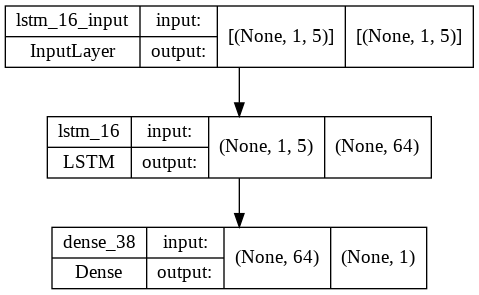

In [ ]:
tf.keras.utils.plot_model(lstm_model, show_shapes=True)


In [ ]:
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')

# Plot test data vs prediction
def plot_future(prediction, model_name, y_test):
    
    plt.figure(figsize=(10, 6))
    
    range_future = len(prediction)

    plt.plot(np.arange(range_future), np.array(y_test), label='Test data')
    plt.plot(np.arange(range_future), np.array(prediction),label='Prediction')

    plt.title('Test data vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Time (day)')
    plt.ylabel('Daily water consumption ($m^3$/capita.day)')



def evaluate_prediction(predictions, actual, model_name):

    rmse = mean_squared_error(actual, predictions, squared=False)
    mae = mean_absolute_error(actual, predictions)
    cc = np.corrcoef(predictions,actual)[0,1]


    print(model_name + ':')
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('correlation coefficent :', cc)
    print('')



<div dir=rtl>
نمودار loss برای داده های train  و  validation  به صورت زیر است

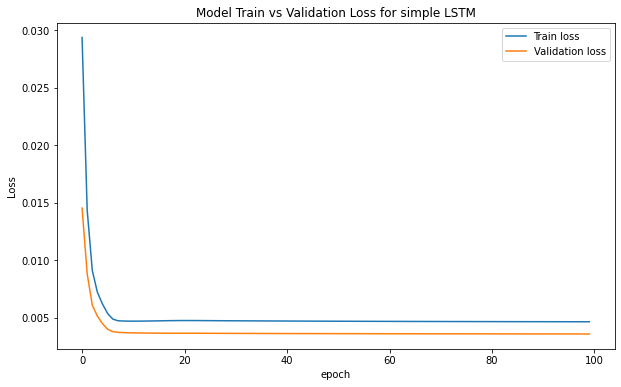

In [ ]:
plot_loss (history_lstm, 'simple LSTM')

<div dir=rtl>
نتایج کلی این شبکه به صورت زیر است 
<br>
همینطور نمودار سرعت باد واقعی و سرعت باد پیشبینی شده در شکل کشیده شده است.

simple LSTM:
Mean Absolute Error: 0.0527
Root Mean Square Error: 0.0691
correlation coefficent : 0.8890458453237132



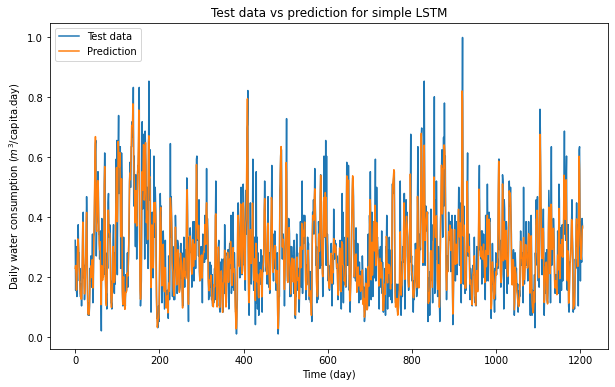

In [ ]:
yhat_lstm = lstm_model.predict(testX)
evaluate_prediction(yhat_lstm[:,0] , testY,"simple LSTM")

plot_future(yhat_lstm[:,0], 'simple LSTM', testY)


In [ ]:
#___________________________________________________________________________________________________________________________
#Bidirectional GRU and Attention Network (BGRU-ATT)


# Bidirectional GRU and Attention Network (BGRU-ATT)
<br>
---input layer---
<br>
(1, 5) model dimension
<br>
( 1, 256) Bidirectional dimension
<br>
---hidden layer---
<br>
( 1, 256) Bidirectional GRU dimension
<br>
( 32) Attention dimension
<br>
---out put layer----
<br>
( 1) Dense dimension
<br>
<div dir=rtl>
 ، همینطور شکل اصلی شبکه در قسمت بعد کشیده شده است ساختار شبکه به صورت نوشته شده در بالا است
<br>
 همانطور که نشان داده شده است از bidirectional Gru به وسلیه ی attention استفاده شده است.
 همینطور در بین شبکه از چند لایه drop out  برای بهتر شدن نتیجه نیز استفاده شده است.
 <br>
برای fit کردن مدل  100 epoch در نظر گفته شده است 
<br>
همینطور مقدار درصد validation data 20 درصد داده های تست در نظر گرفته شده است.
<br>
همینطور از early stopping  بعد از 30 نتیجه یکسان برای validation loss استفاده شده است 
<br>




In [ ]:
import os

from keras import backend as K
from keras.layers import Dense, Lambda, Dot, Activation, Concatenate, Layer

# KERAS_ATTENTION_DEBUG: If set to 1. Will switch to debug mode.
# In debug mode, the class Attention is no longer a Keras layer.
# What it means in practice is that we can have access to the internal values
# of each tensor. If we don't use debug, Keras treats the object
# as a layer and we can only get the final output.
debug_flag = int(os.environ.get('KERAS_ATTENTION_DEBUG', 0))


class Attention(object if debug_flag else Layer):

    def __init__(self, units=128, **kwargs):
        super(Attention, self).__init__(**kwargs)
        self.units = units

    # noinspection PyAttributeOutsideInit
    def build(self, input_shape):
        input_dim = int(input_shape[-1])
        with K.name_scope(self.name if not debug_flag else 'attention'):
            self.attention_score_vec = Dense(input_dim, use_bias=False, name='attention_score_vec')
            self.h_t = Lambda(lambda x: x[:, -1, :], output_shape=(input_dim,), name='last_hidden_state')
            self.attention_score = Dot(axes=[1, 2], name='attention_score')
            self.attention_weight = Activation('softmax', name='attention_weight')
            self.context_vector = Dot(axes=[1, 1], name='context_vector')
            self.attention_output = Concatenate(name='attention_output')
            self.attention_vector = Dense(self.units, use_bias=False, activation='tanh', name='attention_vector')
        if not debug_flag:
            # debug: the call to build() is done in call().
            super(Attention, self).build(input_shape)

    def compute_output_shape(self, input_shape):
        return input_shape[0], self.units

    def __call__(self, inputs, training=None, **kwargs):
        if debug_flag:
            return self.call(inputs, training, **kwargs)
        else:
            return super(Attention, self).__call__(inputs, training, **kwargs)

    # noinspection PyUnusedLocal
    def call(self, inputs, training=None, **kwargs):
        """
        Many-to-one attention mechanism for Keras.
        @param inputs: 3D tensor with shape (batch_size, time_steps, input_dim).
        @param training: not used in this layer.
        @return: 2D tensor with shape (batch_size, units)
        @author: felixhao28, philipperemy.
        """
        if debug_flag:
            self.build(inputs.shape)
        # Inside dense layer
        #              hidden_states            dot               W            =>           score_first_part
        # (batch_size, time_steps, hidden_size) dot (hidden_size, hidden_size) => (batch_size, time_steps, hidden_size)
        # W is the trainable weight matrix of attention Luong's multiplicative style score
        score_first_part = self.attention_score_vec(inputs)
        #            score_first_part           dot        last_hidden_state     => attention_weights
        # (batch_size, time_steps, hidden_size) dot   (batch_size, hidden_size)  => (batch_size, time_steps)
        h_t = self.h_t(inputs)
        score = self.attention_score([h_t, score_first_part])
        attention_weights = self.attention_weight(score)
        # (batch_size, time_steps, hidden_size) dot (batch_size, time_steps) => (batch_size, hidden_size)
        context_vector = self.context_vector([inputs, attention_weights])
        pre_activation = self.attention_output([context_vector, h_t])
        attention_vector = self.attention_vector(pre_activation)
        return attention_vector

    def get_config(self):
        """
        Returns the config of a the layer. This is used for saving and loading from a model
        :return: python dictionary with specs to rebuild layer
        """
        config = super(Attention, self).get_config()
        config.update({'units': self.units})
        return config

In [ ]:
from keras.models import load_model, Model
from keras import Input
num_samples, time_steps, input_dim, output_dim = 2446, 1, 5, 1
units = 128
model_input = Input(shape=(time_steps, input_dim))
#print(model_input.shape , "model input")
#input layer
x = Bidirectional(GRU(units, return_sequences=True))(model_input)
#print(x.shape , "Bidirectional input")
x = Dropout(0.14)(x)
#hidden layer 
x = Bidirectional(GRU(units, return_sequences=True))(x)
#print(x.shape , "Bidirectional input")
x = Attention(units=32)(x)
#print(x.shape , "Attention input")
x = Dropout(0.15)(x)
x = Dense(1)(x)
#print(x.shape , "Dense input")
model_bgru_att = Model(model_input, x)
model_bgru_att.compile(loss='mean_squared_error', optimizer='adam')

early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',patience = 30)
history_bgru_att = model_bgru_att.fit(trainX, trainY, epochs = 100, validation_split = 0.2, batch_size = 32, shuffle = False, callbacks = [early_stop] , verbose=2)




Epoch 1/100
62/62 - 12s - loss: 0.0256 - val_loss: 0.0049 - 12s/epoch - 193ms/step
Epoch 2/100
62/62 - 1s - loss: 0.0070 - val_loss: 0.0043 - 908ms/epoch - 15ms/step
Epoch 3/100
62/62 - 1s - loss: 0.0059 - val_loss: 0.0037 - 1s/epoch - 19ms/step
Epoch 4/100
62/62 - 2s - loss: 0.0057 - val_loss: 0.0036 - 2s/epoch - 26ms/step
Epoch 5/100
62/62 - 2s - loss: 0.0060 - val_loss: 0.0038 - 2s/epoch - 25ms/step
Epoch 6/100
62/62 - 1s - loss: 0.0067 - val_loss: 0.0043 - 775ms/epoch - 13ms/step
Epoch 7/100
62/62 - 1s - loss: 0.0063 - val_loss: 0.0037 - 857ms/epoch - 14ms/step
Epoch 8/100
62/62 - 1s - loss: 0.0056 - val_loss: 0.0037 - 939ms/epoch - 15ms/step
Epoch 9/100
62/62 - 1s - loss: 0.0056 - val_loss: 0.0042 - 857ms/epoch - 14ms/step
Epoch 10/100
62/62 - 1s - loss: 0.0057 - val_loss: 0.0036 - 857ms/epoch - 14ms/step
Epoch 11/100
62/62 - 1s - loss: 0.0056 - val_loss: 0.0037 - 894ms/epoch - 14ms/step
Epoch 12/100
62/62 - 1s - loss: 0.0056 - val_loss: 0.0036 - 887ms/epoch - 14ms/step
Epoch 13/1

بلاک کلی شبکه به صورت زیر است

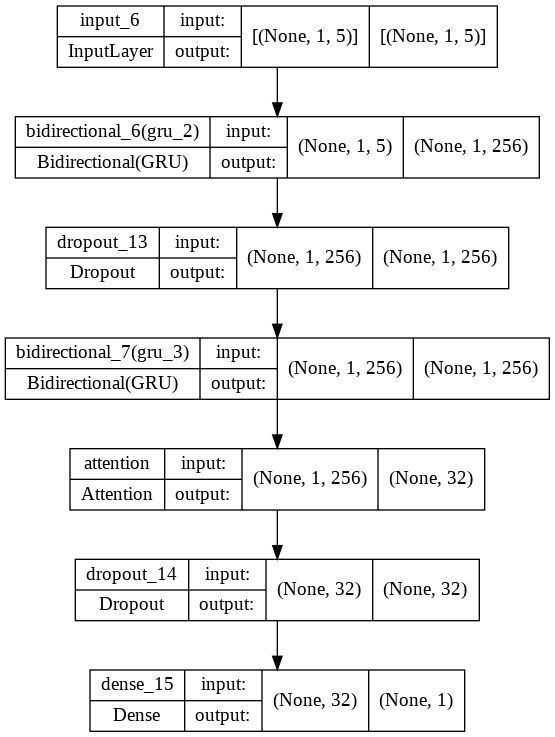

In [ ]:
tf.keras.utils.plot_model(model_bgru_att, show_shapes=True)


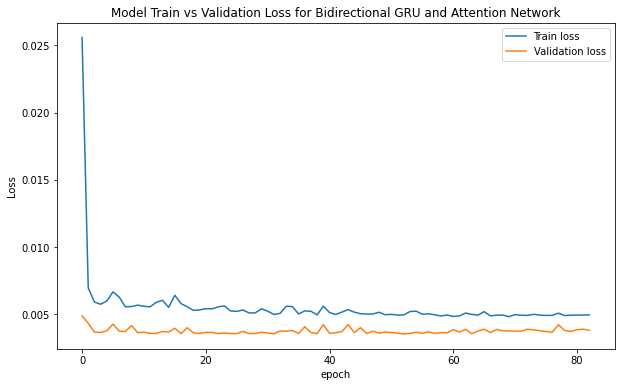

In [ ]:
plot_loss (history_bgru_att, 'Bidirectional GRU and Attention Network')

Bidirectional GRU and Attention Network:
Mean Absolute Error: 0.0538
Root Mean Square Error: 0.0703
correlation coefficent : 0.8865857782213931



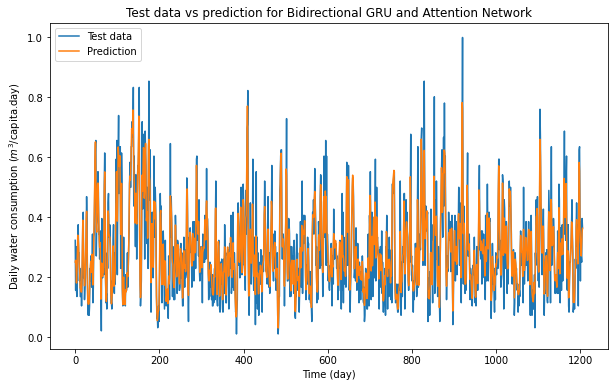

In [ ]:
yhat_bgru_att = model_bgru_att.predict(testX)

evaluate_prediction(yhat_bgru_att[:,0] , testY,"Bidirectional GRU and Attention Network")
plot_future(yhat_bgru_att[:,0], 'Bidirectional GRU and Attention Network', testY)

In [ ]:
#________________________________________________________________


In [ ]:
# from keras.models import load_model, Model
# from keras import Input
# from keras.layers import MultiHeadAttention
# from keras.layers import LayerNormalization
# from keras.layers import Dropout , ReLU , Add  , BatchNormalization ,Embedding,Bidirectional,LSTM
# from keras_nlp.layers import SinePositionEncoding
# #________________transformer_encoder____________________
# num_samples, time_steps, input_dim, output_dim = 2446, 1, 5, 1
# units = 128
# head_size=128
# num_heads=4
# dropout = 0.2

# model_input = Input(shape=(time_steps, input_dim))
# print(model_input.shape , "model input1")
# # #_________inputembedding
# output_embeding = 128 
# x=Embedding( input_dim, output_embeding , embeddings_initializer="uniform")(model_input)
# print(x.shape , "output shape of Embedding")
# #_________MultiHeadAttention
# fx = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(model_input,model_input)
# print(fx.shape , "output shape of MultiHeadAttention")
# #______ add and norm 
# res = Add()([model_input,fx])
# out =ReLU()(res)
# out = BatchNormalization()(out)
# out = Dropout(dropout)(out)
# print(out.shape , "output shape of residual")
# # ________BLSTM 
# x = out
# fx = layers.LayerNormalization(epsilon=1e-6)(out)
# print(fx.shape , "output shape of LayerNormalization")
# fx = Bidirectional(LSTM(units, return_sequences=True))(fx)
# print(fx.shape , "Bidirectional")
# fx = Dense(1,activation='linear')(fx)
# print(fx.shape , "dence")
# #________residual 
# res = Add()([x,fx])
# out =ReLU()(res)
# out = layers.BatchNormalization()(out)
# out = layers.Dropout(dropout)(out)
# print(out.shape , "output shape of residual")
# #________linear
# fx = Dense(1,activation='linear')(fx)
# print(fx.shape , "dence")
# #_____________________________________
# model_blstm_tra = Model(model_input, x)
# model_blstm_tra.compile(loss='mean_squared_error', optimizer='adam')

# early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',patience = 20)
# history_blstm_tra= model_blstm_tra.fit(trainX, trainY, epochs = 100, validation_split = 0.2, batch_size = 16, shuffle = False, callbacks = [early_stop] , verbose=2)






# Bi-LSTM and Transformer 
<br>
<div dir=rtl>
برای این قسمت از مقاله زیر استفاده شده است 
  TRANS-BLSTM: Transformer with Bidirectional LSTM for Language
Understanding 
 شکل توضیح داده شده در بلاک بعدی قابل مشاهده است:
 <br>
با استفاده از این مقاله مدل را در قسمت بعد train کرده ایم
<br>
همنیطورشکل مدل پیاده سازی شده بعد از مدل ترین شده نمایش داده میشود.
<br>
<br>
ساخت مدل : 
 برای این کار ابتدا input مورد نظر  به یک Multi head attention  میدهیم و سپس به صورت resiual مقدار وردی و خروجی multi head attention  را با هم جمع کرده و نرمال میکنیم.
 <br>
 بعد از آن خروجی را به یک شبکه fead fowrward میدهیم 
 همینطور به صورت موازی BLSTM  را پیاده سازی کردی و حاصل خروجی fead forward را با BLSTM  حمع میکنیم و در انتها از یک شبکه linear  عبور میدهیم
 <br>
 همه این مراحل در کد پیاده سازی شده 
 <br>
 برای fit کردن مدل 100 epoch در نظر گفته شده است
همینطور مقدار درصد validation data 20 درصد داده های تست در نظر گرفته شده است.
همینطور از early stopping بعد از 30 نتیجه یکسان برای validation loss استفاده شده است 

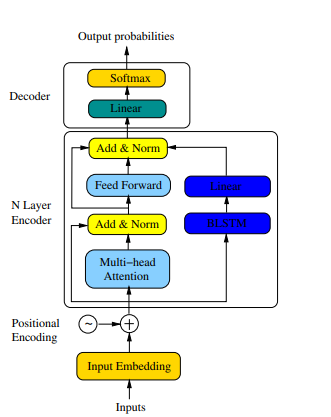

In [ ]:
from IPython.display import display, Image
display(Image(filename='/content/gdrive/MyDrive/Colab_Notebooks/hw3/shabeke.PNG'))

In [ ]:

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    #______ MultiHeadAttention Attention
    
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = layers.Dropout(dropout)(x)
    #________ residual 
    res = x + inputs
    x = layers.LayerNormalization(epsilon=1e-6)(res)

    #________ Feed Forward Part
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)

    return x + res 


def build_model(input_shape,
    head_size,num_heads,ff_dim, units,dropout=0, mlp_dropout=0,):


    inputs = keras.Input(shape=input_shape)
    x = inputs
    #____transformer encoder 
    x  = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
   
    #_____ bidirectional  and linear parallel to other part 
    fx = Bidirectional(LSTM(units, return_sequences=True))(inputs)
    fx = Dense(1,activation='linear')(fx)

    # add and norm
    res = fx + x 
    # x = layers.LayerNormalization(epsilon=1e-6)(x)
    # x = layers.Dense(units, activation="relu")(x)

    res = layers.GlobalAveragePooling1D(data_format="channels_first")(res)
    res = layers.Dense(units, activation="relu")(res)
    res = layers.Dropout(mlp_dropout)(res)
    outputs = Dense(1,activation='linear')(res)

    return keras.Model(inputs, outputs)



input_shape = trainX.shape[1:]
print(input_shape)
model_blstm_tra = build_model(
    input_shape,
    head_size=128,
    num_heads=4,
    ff_dim=5,
    units=128,
    mlp_dropout=0.25,
    dropout=0.2,
)

model_blstm_tra.compile(
    loss="mean_squared_error",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["mean_squared_error"],
)
# model_blstm_tra.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=30, restore_best_weights=True)]

history_blstm_tra = model_blstm_tra.fit(
    trainX,
    trainY,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose = 2
)






(1, 5)
Epoch 1/100
62/62 - 8s - loss: 0.0645 - mean_squared_error: 0.0645 - val_loss: 0.0253 - val_mean_squared_error: 0.0253 - 8s/epoch - 121ms/step
Epoch 2/100
62/62 - 1s - loss: 0.0347 - mean_squared_error: 0.0347 - val_loss: 0.0140 - val_mean_squared_error: 0.0140 - 642ms/epoch - 10ms/step
Epoch 3/100
62/62 - 1s - loss: 0.0212 - mean_squared_error: 0.0212 - val_loss: 0.0088 - val_mean_squared_error: 0.0088 - 655ms/epoch - 11ms/step
Epoch 4/100
62/62 - 1s - loss: 0.0164 - mean_squared_error: 0.0164 - val_loss: 0.0066 - val_mean_squared_error: 0.0066 - 595ms/epoch - 10ms/step
Epoch 5/100
62/62 - 1s - loss: 0.0144 - mean_squared_error: 0.0144 - val_loss: 0.0059 - val_mean_squared_error: 0.0059 - 618ms/epoch - 10ms/step
Epoch 6/100
62/62 - 1s - loss: 0.0135 - mean_squared_error: 0.0135 - val_loss: 0.0055 - val_mean_squared_error: 0.0055 - 627ms/epoch - 10ms/step
Epoch 7/100
62/62 - 1s - loss: 0.0124 - mean_squared_error: 0.0124 - val_loss: 0.0054 - val_mean_squared_error: 0.0054 - 655m

In [ ]:
# tf.keras.utils.plot_model(model_blstm_tra, show_shapes=True)

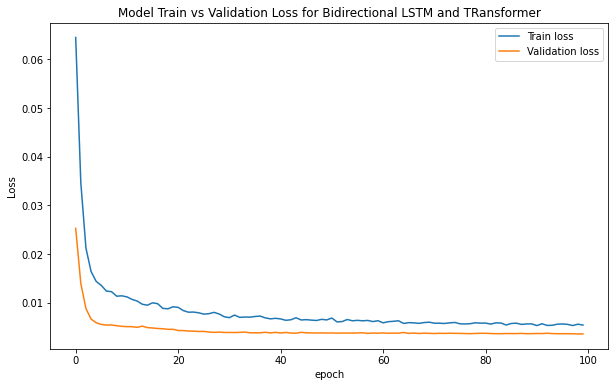

In [ ]:
plot_loss (history_blstm_tra, 'Bidirectional LSTM and TRansformer')

Bidirectional LSTM and Transformer:
Mean Absolute Error: 0.0533
Root Mean Square Error: 0.0700
correlation coefficent : 0.885563620290089



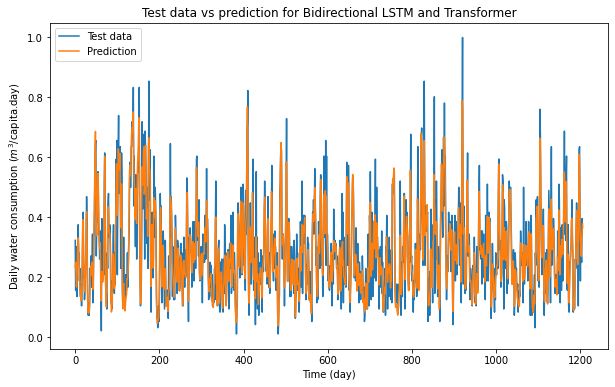

In [ ]:
yhat_blstm_tra = model_blstm_tra.predict(testX)

evaluate_prediction(yhat_blstm_tra[:,0] , testY,"Bidirectional LSTM and Transformer")
plot_future(yhat_blstm_tra[:,0], 'Bidirectional LSTM and Transformer', testY[:])

# مقایسه نتایج نهایی

In [ ]:
evaluate_prediction(yhat_lstm[:,0] , testY,"simple LSTM")
evaluate_prediction(yhat_bgru_att[:,0] , testY,"Bidirectional GRU and Attention Network")
evaluate_prediction(yhat_blstm_tra[:,0] , testY,"Bidirectional LSTM and Transformer")



simple LSTM:
Mean Absolute Error: 0.0527
Root Mean Square Error: 0.0691
correlation coefficent : 0.8890458453237132

Bidirectional GRU and Attention Network:
Mean Absolute Error: 0.0538
Root Mean Square Error: 0.0703
correlation coefficent : 0.8865857782213931

Bidirectional LSTM and Transformer:
Mean Absolute Error: 0.0533
Root Mean Square Error: 0.0700
correlation coefficent : 0.885563620290089



#**رفرنس های استفاده شده در این پروژه**





---



In [ ]:
# refrences
#lstm
# https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
#https://towardsdatascience.com/predictive-analytics-time-series-forecasting-with-gru-and-bilstm-in-tensorflow-87588c852915
#https://github.com/NioushaR/LSTM-TensorFlow-for-Timeseries-forecasting/blob/master/Time%20series.ipynb
#https://www.analyticsvidhya.com/blog/2022/01/tutorial-on-rnn-lstm-gru-with-implementation/
#https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
#bgru_att
#https://github.com/philipperemy/keras-attention-mechanism/tree/master/attention
#https://towardsdatascience.com/time-series-forecasting-with-deep-learning-and-attention-mechanism-2d001fc871fc
#bilstm trans 
#https://towardsdatascience.com/residual-blocks-building-blocks-of-resnet-fd90ca15d6ec
#https://stackoverflow.com/questions/64792460/how-to-code-a-residual-block-using-two-layers-of-a-basic-cnn-algorithm-built-wit